In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoTetramer(specifications.CoiledCoil):
    """Specification for creating antiparallel, homotetrameric coiled coils."""
    
    oligomeric_state = 4
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 4 helices, we have 4 values for each of these, but in this case they
        # are the same as we're making a homotetramer
        self.aas = [helix_length, helix_length, helix_length, helix_length]
        self.major_radii = [radius, radius, radius, radius]
        self.major_pitches = [pitch, pitch, pitch, pitch]
        #self.z_shifts = [0, zshift, 0, zshift]
        self.phi_c_alphas = [phica, phica, phica, phica]
        
        # We need to set the orientation of the helices
        self.orientations = [1, -1, 1, -1] # antiparallel specification

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY', 
             'GEIAALKQEIAALKKENAALKWEIAALKQGYY']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [11]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 6.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27),
]

In [12]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 6.0, 200, 154.2]


### Genetic Algorithm

In [13]:
opt_ga = ev_opts.GA(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [14]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	75   	-1185.76	526.331	-1816.37	51.8603
1  	84   	-1607.85	96.3254	-1850.85	-1459.98
2  	59   	-1697.74	88.1009	-1865.19	-1555.97
3  	56   	-1766.14	70.3357	-1897.8 	-1647.06
4  	72   	-1836.4 	29.2238	-1897.8 	-1775.65
5  	64   	-1860.45	16.3352	-1898.93	-1831.43
6  	60   	-1875   	13.6168	-1904.62	-1853.49
7  	66   	-1886.02	10.9085	-1904.7 	-1864.35
8  	76   	-1896.9 	4.78032	-1906.55	-1886.72
9  	75   	-1900.54	3.50108	-1908.05	-1894.69
10 	67   	-1903.55	2.39887	-1908.29	-1898.26
11 	82   	-1905.39	1.00567	-1908.29	-1903.57
12 	68   	-1906.32	0.987709	-1908.67	-1904.76
13 	72   	-1907.26	0.853366	-1909.1 	-1905.85
14 	71   	-1907.96	0.539147	-1909.1 	-1906.65
15 	58   	-1908.25	0.348672	-1909.1 	-1907.53
16 	83   	-1908.57	0.218859	-1909.17	-1908.23
17 	67   	-1908.71	0.207673	-1909.38	-1908.4 
18 	77   	-1908.86	0.192557	-1909.43	-1908.58
19 	69   	-1908.96	0.180573	-1909.43	-1908.68
20 	75   	-1909.05	0.142607	-1909.43	-1908.83
21 

In [15]:
optimized_model_ga = opt_ga.best_model

In [16]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-1909.4732279331513

In [17]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [18]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

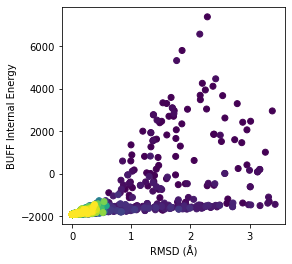

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [20]:
f = open('d_CC-Di_tetramer_antiparallel-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [21]:
opt_de = ev_opts.DE(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [22]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-461.886	1293.31	-1775.94	4126.57
1  	100  	-972.814	724.051	-1775.94	2952.95
2  	100  	-1311.31	314.362	-1775.94	-218.391
3  	100  	-1465.7 	208.982	-1813.62	-819.709
4  	100  	-1565.9 	129.932	-1820.29	-1096.42
5  	100  	-1635.83	105.347	-1865.55	-1265.28
6  	100  	-1681.52	88.4932	-1865.55	-1427.29
7  	100  	-1724   	73.3326	-1878.04	-1517.85
8  	100  	-1759.68	67.2039	-1891.65	-1584.1 
9  	100  	-1788.78	60.9172	-1891.65	-1660.66
10 	100  	-1812.64	52.4887	-1891.72	-1686.81
11 	100  	-1836.13	43.1358	-1905.74	-1726.91
12 	100  	-1852.64	36.1196	-1905.74	-1726.91
13 	100  	-1868.69	24.8988	-1907.19	-1773.61
14 	100  	-1879.8 	16.5796	-1910.02	-1824.53
15 	100  	-1888.13	12.214 	-1910.02	-1856.35
16 	100  	-1892.17	10.2774	-1910.02	-1856.44
17 	100  	-1895.44	8.30885	-1910.02	-1861.03
18 	100  	-1899.56	6.21291	-1910.02	-1880.95
19 	100  	-1902.32	5.08131	-1910.02	-1889.64
20 	100  	-1904.7 	3.90731	-1910.64	-1892   
21 	100  	-19

In [23]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-1911.596880874638

In [24]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [25]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

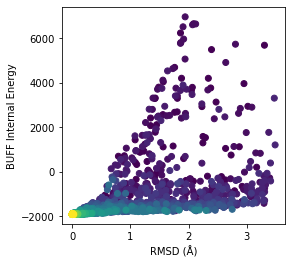

In [26]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [27]:
f = open('d_CC-Di_tetramer_antiparallel-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [28]:
opt_pso = ev_opts.PSO(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [29]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-680.562	1265.73	-1807.88	4565.81
1  	82   	-1368.87	674.73 	-1948.73	1913.27
2  	44   	-1457.35	564.892	-1948.73	1913.27
3  	66   	-1266.61	524.391	-1948.73	742.87 
4  	83   	-1121.63	956.661	-1948.73	3269.12
5  	81   	-1134.43	1203.19	-1926.48	6825.47
6  	69   	-1238.77	988.22 	-1926.48	4864.27
7  	76   	-1301.18	476.08 	-1926.48	411.852
8  	83   	-1276.61	535.715	-1817.55	1343.61
9  	77   	-1206.75	671.878	-1846.49	1391.5 
10 	69   	-801.841	1204.85	-1846.49	3984.72
11 	82   	-903.423	960.422	-1830.22	3004.32
12 	88   	-1200.78	627.977	-1809.53	1423.5 
13 	80   	-1284.04	919.492	-1907.24	4026.09
14 	54   	-1299.97	884.229	-1907.24	4026.09
15 	29   	-1348.1 	650.634	-1907.24	1272.51
16 	36   	-1330.71	829.055	-1923.51	3434.7 
17 	73   	-1378.78	484.428	-1923.51	1647.77
18 	64   	-1411.04	650.264	-1923.51	2443.35
19 	58   	-1393.91	748.608	-1923.51	2282.66
20 	55   	-1363.25	856.301	-1940.01	4940.16
21 	58   	-1125.25	1045.77	-1940

In [30]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-1948.7320751357552

In [31]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [32]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

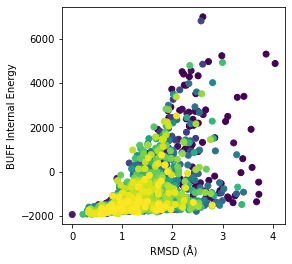

In [33]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [34]:
f = open('d_CC-Di_tetramer_antiparallel-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [35]:
opt_cmaes = ev_opts.CMAES(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [36]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max    
0  	100  	411.904	1305.82	-1484.19	5095.79
1  	100  	-512.745	1369.12	-1756.58	4241.36
2  	100  	-988.215	1045.11	-1885.5 	2530.27
3  	100  	-1602.08	207.049	-1890.74	-595.018
4  	100  	-1752.08	90.2176	-1894.11	-1525.4 
5  	100  	-1825.35	61.4551	-1909.67	-1544.32
6  	100  	-1850.7 	36.0877	-1907.21	-1682.73
7  	100  	-1876.78	18.9703	-1909.32	-1804.79
8  	100  	-1890.75	10.678 	-1906.69	-1860.05
9  	100  	-1897.3 	6.93181	-1907   	-1876.55
10 	100  	-1901.33	6.01422	-1908.99	-1865.26
11 	100  	-1900.86	11.2292	-1911.06	-1861.53
12 	100  	-1896.89	15.6742	-1910.06	-1855.62
13 	100  	-1905.25	8.66003	-1911.34	-1861.64
14 	100  	-1903.25	11.0609	-1911.15	-1863.6 
15 	100  	-1906.3 	7.5718 	-1911.54	-1865.79
16 	100  	-1905.04	11.0707	-1911.88	-1863.72
17 	100  	-1903.91	10.8912	-1912.18	-1864.37
18 	100  	-1902.98	11.1635	-1912.24	-1864.23
19 	100  	-1904.11	9.17227	-1912.05	-1881.22
20 	100  	-1904.6 	9.24799	-1911.94	-1863.65
21 	100  	-1903.

In [37]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-1912.2748923249735

In [38]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [39]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

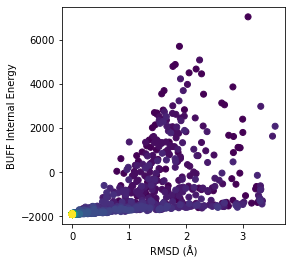

In [40]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [41]:
f = open('d_CC-Di_tetramer_antiparallel-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)